In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [2]:
def train_lstm_model(data):
    data = data.reshape(-1, 1)

    # Приводим данные к диапазону от 0 до 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Создаем тренировочный и тестовый наборы данных
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]


    def create_dataset(dataset, time_step=1):
        X, Y = [], []
        for i in range(len(dataset) - time_step - 1):
            X.append(dataset[i:(i + time_step), 0])
            Y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(Y)


    time_step = 60
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Изменяем форму данных для входа в LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Создаем модель LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    model.fit(X_train, y_train, batch_size=1, epochs=1)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions, train_size, time_step


1155/1155 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 19.5295
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


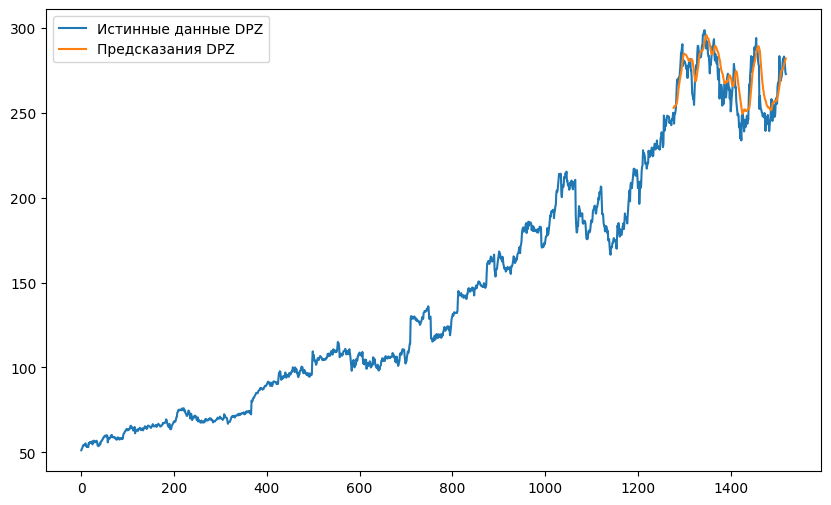

In [3]:
df = pd.read_csv('../data/portfolio_data.csv')

# columns = ['AMZN', 'DPZ', 'NFLX', 'BTC']
columns = ['DPZ']
for column in columns:
    data = df[column].values
    predictions, train_size, time_step = train_lstm_model(data)

    # Визуализируем результаты
    plt.figure(figsize=(10, 6))
    plt.plot(df[column].values, label=f'Истинные данные {column}')
    x_range = range(train_size + time_step + 1, train_size + time_step + 1 + len(predictions))
    plt.plot(x_range, predictions, label=f'Предсказания {column}')
    plt.legend()
    plt.show()
